# 1. Introduction

This is a lab for experimenting with trend-following ideas and techniques.  It includes the following features:

1. Data: downloads historical price data from various sources as input to the experiments.  It also simulates price data with various models to test different strategies.
1. `tr` class: a class for trading strategies upon a single asset.
1. `po` class: a class for portfolio evaluation: select assets, excecute trading strategies and evaluate performance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

In [3]:
# Utils
def dict_list_to_DataFrame(dl): 
    dl = [{k: [i] for k, i in d.items()} for d in dl]
    out = pd.concat([DataFrame.from_dict(d) for d in dl], sort=False)
    return out

# 2. Data

The main sources of data are `Quandl`, `Cryptocompare` and `Yahoo Finance`.

## Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

In [7]:
QUANDL_PATH = 'input/Quandl/'
# ! ls {QUANDL_PATH}
print(os.listdir(QUANDL_PATH))

['SCF.csv', 'SCF.xlsx', 'XASE.csv', 'XASE.pickle', 'XBOM.csv', 'XBOM.pickle', 'XHKG.csv', 'XHKG.pickle', 'XLON.csv', 'XLON.pickle', 'XNAS.csv', 'XNAS.pickle', 'XNSE.csv', 'XNSE.pickle', 'XNYS.csv', 'XNYS.pickle', 'XSES.csv', 'XSES.pickle', 'XSHE.csv', 'XSHE.pickle', 'XSHG.csv', 'XSHG.pickle', 'XTSE.csv', 'XTSE.pickle', 'XTSX.csv', 'XTSX.pickle']


In [8]:
# Free sample tickers from Exchange Data International
QUANDL_FREE_SAMPLES_EDI = {
    # https://www.quandl.com/data/XNAS-NASDAQ-Stock-Market-Prices
    'XNAS': ['AAL', 'AAME', 'AAON', 'AAPL', 'AAXJ', 'ABAC', 'ABAX',
             'ABCO', 'ABG', 'ABM', 'ABTL', 'ACET', 'ACIW', 'ACLS', 'ACNB'],
    # https://www.quandl.com/data/XBOM-Bombay-Stock-Exchange-Prices
    'XBOM': ['500002', '500003', '500008', '500010', '500012',
             '500013', '500020', '500023', '500024', '500027',
             '500031', '500032', '500038', '500039', '500040'],
    # https://www.quandl.com/data/XTSE-Toronto-Stock-Exchange-Prices
    'XTSE': ['AAB', 'ABT', 'ABX', 'ACD', 'ACQ', 'AEM', 'AFN', 'AGT',
             'AGU', 'AIF', 'ALA', 'ALB', 'ALC', 'ALO', 'AND'],
    # https://www.quandl.com/data/XSHG-Shanghai-Stock-Exchange-Prices
    'XSHG' : ['600000', '600004', '600006', '600007', '600009',
              '600010', '600011', '600012', '600015', '600016',
              '600017', '600019', '600020', '600021', '600026'],
    # https://www.quandl.com/data/XLON-London-Stock-Exchange-Prices
    'XLON': ['AAIF', 'AAL', 'AAS', 'ABBY', 'ABC', 'ABF', 'ADIG', 
             'ADM', 'ADT', 'AEFS', 'AEO', 'AEP', 'AFN', 'AFS', 'AGK'],
    # https://www.quandl.com/data/XSES-Singapore-Exchange-Prices
    'XSES': ['1B6', '1C0', 'A04', 'A05', 'AFC', 'AGS', 'AUE', 'AVX', 
             'BBW', 'BCD', 'BCV', 'BCX',  'BCY', 'BEC', 'BESU'],
    # https://www.quandl.com/data/XNYS-New-York-Stock-Exchange-Prices
    'XNYS': ['A', 'AAT', 'AB', 'ABB', 'ABBV', 'ABC', 'ABEV', 'ABG', 
             'ABM', 'ABR', 'ABT', 'ABX', 'ACC', 'ADC', 'ADM'],
    # https://www.quandl.com/data/XHKG-Hong-Kong-Stock-Exchange-Prices
    'XHKG': ['00002', '00003', '00004', '00005', '00006',
             '00008', '00010', '00011', '00012', '00014',
             '00015', '00016', '00017', '00018', '00019'],
    # https://www.quandl.com/data/XASE-NYSE-MKT-AMEX-Prices
    'XASE': ['ABE', 'ACU', 'ACY', 'ADK', 'AE',  'AMS', 'ARNC_P',
             'BAA', 'BDL', 'BFY', 'BHB', 'BHV', 'BLE', 'BLJ', 'BTI'],
    # https://www.quandl.com/data/XNSE-National-Stock-Exchange-of-India-Prices
    'XNSE': ['ABB', 'ACC', 'ACE', 'ADSL', 'AFL', 'ALICON',
             'BAJAJ_AUTO', 'BASF', 'BASML', 'BBL', 'BEL',
             'BEPL, BHEL', 'BIL', 'BIOCON'],
    # https://www.quandl.com/data/XTSX-Toronto-Ventures-Stock-Exchange-Prices
    'XTSX': ['ABI', 'ABN', 'ADD', 'ADK', 'ADL', 'AFCC', 'AFM', 'AGD', 
             'AGO', 'AHR', 'AIIM', 'ALT', 'ALZ', 'AME', 'AMK'],
    # https://www.quandl.com/data/XSHE-Shenzhen-Stock-Exchange-Prices
    'XSHE': ['200011', '200012', '200018', '200025', '200026',
             '200055', '200056', '200413', '200418', '200488',
             '200521', '200530', '200539', '200541', '200550'],
    # https://www.quandl.com/data/XJPX-Japan-Exchange-Group-Prices/documentation/coverage
    'XJPX': ['13010', '13050', '13060', '13080', '13100', '13110', 
             '13200', '13290', '13300', '13320', '13430', '13440', 
             '13450', '13480', '13760']
}

In [9]:
def saf_quandl_get(dataset, **kwargs):
    try:
        return quandl.get(dataset, **kwargs)
    except:
        return None


def get_quandl_edi(exchanges = 'XNAS', free=True, download=False, flatten=True, verbose=False):
    """
    Downloads price series from Quandl vendor Exchange Data International
    
    Parameters
    ----------
    exchanges : List with names of the exchanges from which to download prices.
    free : If True, only free sample prices are downloaded.
    download : 
        If True, downloads the prices from quandl.  
        If False, looks for previously downloaded results in the QUANDL_PATH folder.
    verbose : If True, prints downloaded tickers.
    flatten: If True, returns a flattened dict with the results.
    
    Returns
    -------
    out : a dict or dict of dicts, of pandas DataFrame for each ticker.
    """
    
    out = dict()
    
    if download:
        for x in exchanges:
            
            prices = pd.read_csv(QUANDL_PATH + x + '.csv', names=['Ticker', 'Desc.'])
            free_sample = QUANDL_FREE_SAMPLES_EDI[x]
            which_free = [re.search('|'.join(free_sample), t) is not None and re.search('_UADJ', t) is None
                          for t in prices['Ticker']]
            if free: 
                prices = prices[which_free]
                
            if verbose:
                print('Downloading prices from', x, '...')
                
            out[x] = {t: saf_quandl_get(t) for t in prices['Ticker']}
            out[x] = {k: i for k, i in out[x].items() if i is not None}
            
            with open(QUANDL_PATH + x + '.pickle', 'wb') as f:
                pickle.dump(out[x], f, pickle.HIGHEST_PROTOCOL)
            
            if verbose:
                print(list(out[x].keys()))
    
    else:
        for x in exchanges:
            try:
                with open(QUANDL_PATH + x + '.pickle', 'rb') as f:
                    out[x] = pickle.load(f)
            except:
                pass
    
    if flatten:
        out = {k: i for x in out.keys() for k, i in out[x].items()}
    
    out = {k: i[['Open', 'High', 'Low', 'Close', 'Volume']] for k, i in out.items()}

    return out

# prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()), download=True, verbose=True)

In [10]:
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
print(list(prices_dict.keys()))

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET', 'XNAS/ACNB', 'XNAS/AAPL', 'XNAS/AAME', 'XNAS/ACLS', 'XNAS/AAL', 'XNAS/ABCO', 'XNAS/ABG', 'XNAS/ABAC', 'XNAS/ACIW', 'XBOM/500003', 'XBOM/500008', 'XBOM/500012', 'XBOM/500013', 'XBOM/500002', 'XBOM/500023', 'XBOM/500024', 'XBOM/500027', 'XBOM/500031', 'XBOM/500032', 'XBOM/500038', 'XBOM/500039', 'XBOM/500020', 'XBOM/500040', 'XBOM/500010', 'XTSE/AND', 'XTSE/AFN', 'XTSE/AGT', 'XTSE/ACQ', 'XTSE/ALA', 'XTSE/AIF', 'XTSE/ALB', 'XTSE/ALO', 'XTSE/ABT', 'XTSE/ACD', 'XTSE/AEM', 'XTSE/AGU', 'XTSE/ALC', 'XTSE/ABX', 'XTSE/AAB', 'XSHG/600020', 'XSHG/600015', 'XSHG/600021', 'XSHG/600019', 'XSHG/600009', 'XSHG/600016', 'XSHG/600007', 'XSHG/600000', 'XSHG/600006', 'XSHG/600017', 'XSHG/600011', 'XSHG/600010', 'XSHG/600026', 'XSHG/600012', 'XSHG/600004', 'XLON/ADM', 'XLON/ABC', 'XLON/AFS', 'XLON/AAIF', 'XLON/ADT', 'XLON/AEFS', 'XLON/AAS', 'XLON/AFN', 'XLON/AGK', 'XLON/AAL', 'XLON/AEP', 'XLON/ABF', 'XLON/ADIG', 'XLON/ABBY', 'XLON/AEO', 'XSES/

j: 126  -  XASE/BHB


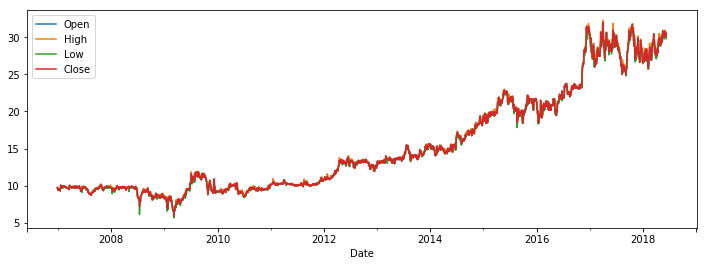

In [11]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [12]:
prices_dict[ticker_j].head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-12-28,9.749216,9.749216,9.676438,9.703730,500.0
2006-12-29,9.643081,9.643081,9.627919,9.627919,500.0
2007-01-01,9.627919,9.627919,9.627919,9.627919,0.0
2007-01-02,9.627919,9.627919,9.627919,9.627919,0.0
2007-01-03,9.567271,9.567271,9.339840,9.370164,3200.0


## Cryptocompare

## Yahoo Finance

## Data pre-processing

* OHLC: open and close within [low, high].

# 3. Trading Strategies

## 3.1 Definitions

In [346]:
class Trade:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, name='', strategy=None, skid=0.5):
        """
        Initializes trade class.
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
        strategy : An instance of class trading_strategy.
        name : name of the asset to trade.
        skid : skid for excecution of orders in the strategy (see http://www.seykota.com/tribe/TSP/SR/index.htm)
        """
        self.name = name
        self.prices = prices.sort_index()
        self.limit_orders = None
        self.trades = None
        self.value = None
        self.skid = skid
        self.strategy = strategy
    
    
    def plot_prices(self):
        self.prices[['Open', 'High', 'Low', 'Close']].plot()
        plt.title(self.name)


class Trading_Strategy:
    """
    Class that defines a trading strategy.
    """
    
    def __init__(self, prices, equity=100, heat=0.05, position_step=100, name=''):
        """
        Defines the initial state and hyper parameters of the trading strategy.
        
        Parameters
        ----------
        prices: DataFrame with columns Date, Open, High, Low, Close
        equity: Initial equity to invest in the asset.
        heat: Proportion of the equity that one is willing to risk.
        position_step: Minimum steps in position' sizes
        name: Name of the asset for plotting purposes.
        """
        self.prices = prices
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today = None
        self.today_prices = None
        self.equity = [{'Date': None,
                        'Available_Balance': equity, 'Closing_Balance': equity,
                        'Position': 0, 'Open_Profit': 0, 
                        'Position_Value': 0, 'Equity': equity}]
        self.max_drawdown = 0
        self.state = []
        self.orders = []
        self.trades = []
        self.performance = {}
    
        
    
    def orders_before_trading_starts(self, prices, prev_day_position, prev_day_state, **kwargs):
        """
        Computes the orders for the day (today).
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
            Prices until today only for accessing current date.
        prev_day_position : position in the asset at the end of yesterday.
        """
        pass
    
    def excecute_orders(self, equity_to_risk=100, skid=0.5):
        """
        Excecutes orders during the day.
        """
        
        if self.equity[-1]['Date'] is None:  # First day: do nothing.
            self.equity[-1]['Date'] = self.prices.index[0]
        else:
            position = self.equity[-1]['Position']  # previous day's position
            balance = self.equity[-1]['Available_Balance']
            o = self.orders[-1]
            tp = self.today_prices
            
            if position == 0:  # Enter the market.
                
                if o['buy_stop'] is not None and o['protective_sell'] is not None and tp.High > o['buy_stop']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['buy_stop']))
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': min(o['amount'], balance)}
                    position += o['amount']
                    balance -= o['amount'] * buy_price
                    self.trades.append(trade)
                    
                    
                elif o['sell_stop'] is not None and o['protective_buy'] is not None and tp.Low < o['sell_stop']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['sell_stop']) - tp.Low)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': max(o['amount'], -balance)}  # o['amount'] < 0
                    position += o['amount']
                    balance -= o['amount'] * sell_price
                    self.trades.append(trade)
                    
            if position != 0:  # Close positions.
                
                if o['protective_buy'] is not None and tp.High > o['protective_buy']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['protective_buy']))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
                    
                if o['protective_sell'] is not None and tp.Low < o['protective_sell']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['protective_sell']) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
            
            if self.today == self.prices.index.values[-1] and position != 0:  # Last day
                if position > 0:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.Close, tp.High) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
                else:  # position < 0
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Close, tp.Low))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
            
            if position != 0:
                open_profit = position * (tp.Close - self.trades[-1]['Price'])
            else:
                open_profit = 0
            
            if self.equity[-1]['Position'] != 0 and position == 0:
                closing_balance = balance
            else:
                closing_balance = self.equity[-1]['Closing_Balance']
            
            
            self.equity.append({'Date': self.today, 'Available_Balance': balance, 'Closing_Balance': closing_balance,
                                'Position': position, 'Open_Profit': open_profit,
                                'Position_Value': position * tp.Close,
                                'Equity': balance + position * tp.Close})
    
    
    def excecute(self, warmup=25, end=None):
        """
        Excecutes the trading strategy and computes its performance measures.
        
        Parameters
        ----------
        warmup: warmup period in days or a proportion from 0 to 1.
        end: either a datetime or a proportion from 0 to 1 (all sample).
        """
        peak = self.equity[0]['Equity']
        low = peak
        drawdown = 0
        max_drawdown = 0
        
        if end is None:
            end = self.prices.index[-1]
        elif type(end) == float:
            end = self.prices.index[int(len(self.prices) * end)]
        
        if warmup < 1:
            warmup = int(len(self.prices) * warmup)
            
        for i in range(1, len(self.prices)):
            self.update_state(i)
            if i >= warmup - 1:
                self.orders_before_trading_starts()
                self.excecute_orders()
                
                # Max drawdown
                if self.equity[-1]['Equity'] > peak:
                    peak = self.equity[-1]['Equity']
                    low = peak
                if self.equity[-1]['Equity'] < low:
                    low = self.equity[-1]['Equity']
                    drawdown = low / peak - 1
                max_drawdown = min(drawdown, max_drawdown)
            if self.today > end:
                break
        
        self.max_drawdown = max_drawdown
        self.compute_performance()
        

    def compute_performance(self):
        """
        Computes performance indicators for the trading strategy.
        """
        # The date in the first entry of equity is None
        self.performance['Years'] = (self.equity[-1]['Date'] - self.equity[1]['Date'] ).days / 364.25
        self.performance['Ratio'] = self.equity[-1]['Equity'] / self.equity[0]['Equity']
        # Instantaneously Compounding Annual Gain
        self.performance['ICAGR'] = np.log(self.performance['Ratio']) / self.performance['Years']
        self.performance['Max_Drawdown'] = -self.max_drawdown
        # How Often the System Earns Back its Biggest Drawdown
        self.performance['Bliss'] = self.performance['ICAGR'] / self.performance['Max_Drawdown']
        
        eqty = np.array([d['Equity'] for d in self.equity][1:])
        self.performance['Volatility'] = np.std(np.log(eqty[1:] / eqty[:-1])) * np.sqrt(364.25)
        
        # Lake Ratio (see http://www.seykota.com/tribe/risk/index.htm)
        lake_bottom = Series(eqty) / self.equity[1]['Equity']
        lake_surface = lake_bottom.cummax()

        earth = np.trapz(lake_bottom.values)
        water = np.trapz(lake_surface - lake_bottom)
        self.performance['Lake_Ratio'] = water / earth
        
        earth0 = np.trapz(lake_bottom.values - 1)
        self.performance['Sea_Ratio'] = water / earth0
        
        
    
    def get_state(self):
        if not any([i == 'state_df' for i in dir(self)]):
            self.state_df = dict_list_to_DataFrame(self.state).set_index('Date')
        return self.state_df
    
    
    def get_orders(self):
        if not any([i == 'orders_df' for i in dir(self)]):
            self.orders_df = dict_list_to_DataFrame(self.orders).set_index('Date')
        return self.orders_df
    
    
    def get_trades(self):
        if not any([i == 'trades_df' for i in dir(self)]):
            self.trades_df = dict_list_to_DataFrame(self.trades).set_index('Date')
        return self.trades_df
    
    
    def get_equity(self):
        if not any([i == 'equity_df' for i in dir(self)]):
            self.equity_df = pd.merge(self.prices[['Open']],
                                      dict_list_to_DataFrame(self.equity).set_index('Date'),
                                      left_index=True, right_index=True,
                                      how='left')
            self.equity_df = self.equity_df.drop('Open', axis=1)
            self.equity_df = self.equity_df.fillna(method='ffill')
        return self.equity_df
    
    
    
    
    def plot_prices(self):
        fig, ax = plt.subplots()
        ax.plot(self.prices[['Open', 'High', 'Low', 'Close']])
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        plt.title(self.name)
        plt.legend()
    
    def plot_state(self):
        pass
    
    def plot_equity(self):
        x = pd.merge(self.get_equity(), self.get_state(), left_index=True, right_index=True, how = 'outer')
        tit = self.name + ' - days_fast: ' + str(self.days_fast) + ', days_slow: ' + str(self.days_slow) + ', '
        tit += 'heat: ' + str(self.heat) + '.\n'
        tit += 'Initial Equity: ' + str(int(self.equity[0]['Equity']))
        tit += ', Ending Equity: ' + str(int(self.equity[-1]['Equity'])) + ', '
        tit += 'Total Return: ' + str(int(10000 * self.equity[-1]['Equity'] / self.equity[1]['Equity'] - 1) / 100) + '%, '
        tit += 'ICAGR: ' + str(int(10000 * self.performance['ICAGR']) / 100) + '%.\n'
        tit += 'Volatility: ' + str(int(10000 * self.performance['Volatility']) / 100) + '%, '
        tit += 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%, '
        tit += 'Max. Drawdown: ' + str(int(10000* self.performance['Max_Drawdown']) / 100) + '%, '
        tit += 'Bliss: ' + str(np.round(364.25 * self.performance['Bliss'], 1)) + ' days.'
        pal = plt.get_cmap('Paired').colors
        fig, ax = plt.subplots()
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend > 0, facecolor=pal[0], alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend < 0, facecolor=pal[4], alpha=0.25, transform=trans, label='Trend down')
        ax.plot(x.index, x.Equity)
        ax.plot(x.index, x.Closing_Balance)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(tit)
        ax.legend()
    
    
    def plot_lake_ratio(self):
        """
        Illustrates the computation of the lake ratio.
        See http://www.seykota.com/tribe/risk/index.htm
        """
        lake_bottom = Series([d['Equity'] for d in self.equity[1:]],
                             index=[d['Date'] for d in self.equity[1:]]) / self.equity[1]['Equity']
        lake_surface = lake_bottom.cummax()
        fig, ax = plt.subplots()
        ax.fill_between(lake_bottom.index, y1 = lake_bottom, y2 = lake_surface, alpha=0.5)
        ax.fill_between(lake_bottom.index, y1 = 0, y2 = lake_bottom, alpha=0.5)
        ax.axhline(1, color='grey', lw=2, alpha=0.75)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.plot(lake_bottom)
        tit = 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%'
        tit += ', Sea Ratio (areas over 1): ' + str(int(10000 * self.performance['Sea_Ratio']) / 100) + '%.'
        ax.set_title(tit)




class RS_Trading_Strategy(Trading_Strategy):
    """
    Implements a Support and Resistance trading system, 
    based on http://www.seykota.com/tribe/TSP/SR/index.htm.
    """
    
    def __init__(self, prices, equity=100000, heat=0.05, position_step=1, days_fast=20, days_slow=140, name=''):
        """
        Parameters
        ----------
        days_fast: days in the moving window for computing the fast support and resistance.
        days_slow: days in the moving window for computing the slow support and resistance.
        """
        self.prices = prices
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today = None
        self.today_prices = None
        self.equity = [{'Date': None,
                        'Available_Balance': equity, 'Closing_Balance': equity,
                        'Position': 0, 'Open_Profit': 0, 
                        'Position_Value': 0, 'Equity': equity}]
        self.peak = equity
        self.low = equity
        self.max_drawdown = 0
        self.state = []
        self.orders = []
        self.trades = []
        self.performance = {}
        self.days_fast = days_fast
        self.days_slow = days_slow
        
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        self.today = self.prices.index[today_i]
        self.today_prices = self.prices.iloc[today_i]
        prices = self.prices.iloc[:today_i]  # All but today
        
        # State calculations
        Support_slow = prices[-self.days_slow:].Low.min()
        Support_fast = prices[-self.days_fast:].Low.min()
        Resistance_slow = prices[-self.days_slow:].High.max()
        Resistance_fast = prices[-self.days_fast:].High.max()
        last_price = prices.iloc[today_i - 1]
        if last_price.High >= Resistance_slow and last_price.Low > Support_slow:
            Trend = 1
        elif last_price.Low <= Support_slow and last_price.High < Resistance_slow:
            Trend = -1
        elif len(self.state) > 0:
            Trend = self.state[-1]['Trend']
        else:
            Trend = 0
        
        self.state.append(dict(Support_slow=Support_slow,
                               Support_fast=Support_fast,
                               Resistance_slow=Resistance_slow,
                               Resistance_fast=Resistance_fast,
                               Trend=Trend,
                               Date=prices.index[-1]))
    
    
    def orders_before_trading_starts(self):
        """
        Computes the orders for the day (today) according to a Support and Resistance system.
        """
        
        # Orders
        prev_day_position = self.equity[-1]['Position']
        equity_to_risk = self.equity[-1]['Available_Balance'] * self.heat
        state = self.state[-1]
        Trend = state['Trend']
        
        orders = dict(Date = self.today,
                      buy_stop = None, sell_stop=None,
                      protective_buy=None, protective_sell=None)
        
        if prev_day_position == 0:
            if Trend == 1:
                orders['buy_stop'] = state['Resistance_fast']
                orders['protective_sell'] = state['Support_fast']
                orders['risk_per_lot'] = orders['buy_stop'] - orders['protective_sell']
                orders['amount'] = self.position_step * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.position_step)
            elif Trend == -1:
                orders['sell_stop'] = state['Support_fast']
                orders['protective_buy'] = state['Resistance_fast']
                orders['risk_per_lot'] = orders['protective_buy'] - orders['sell_stop'] 
                orders['amount'] = - self.position_step * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.position_step)
        elif prev_day_position > 0:
            orders['protective_sell'] = state['Support_fast']
        elif  prev_day_position < 0:
            orders['protective_buy'] = state['Resistance_fast']
        else:
            pass
        
        self.orders.append(orders)
        
        
    def plot_state(self):
        x = pd.merge(self.prices, self.get_state(), left_index=True, right_index=True, how='outer')
        tit = self.name + ' - days_fast: ' + str(self.days_fast) + ', days_slow: ' + str(self.days_slow) + '.'
        pal = plt.get_cmap('Paired').colors
        fig, ax = plt.subplots()
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.High.max(), where= x.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.High.max(), where= x.Trend < 0, facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Trend down')

        ax.plot(x.index, x.High, c=pal[1])
        ax.plot(x.index, x.Low, c=pal[0])
        ax.plot(x.index, x.Resistance_fast, c=pal[2])
        ax.plot(x.index, x.Resistance_slow, c=pal[3])
        ax.plot(x.index, x.Support_fast, c=pal[4])
        ax.plot(x.index, x.Support_slow, c=pal[5])
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.legend()
        ax.set_title(tit)


# rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
#                             days_fast=20, days_slow=140, name='Comex Gold')
# rs_tr.excecute(warmup=20)

## 3.2 Validation

```
import unittest

class Test_RS_Trading_Strategy(unittest.TestCase):
    
    pr_j = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
    pr_j.index = [datetime.strptime(str(i), '%Y%m%d') for i in pr_j.index.values]
    
    rs_tr = RS_Trading_Strategy(pr_j, equity=1e6, tick=1e2)
    rs_tr.excecute()
    
    def test_update_state(self):
        stts = rs_tr.get_state()
        metrics = pd.merge(pr_j[['Open', 'High', 'Low', 'Close']], stts, left_index=True, right_index=True)
        metrics_log = pd.read_excel(io='test/Metrics_Log_1-1.xlsx', index_col=0)
        self.assertTrue(np.all(np.equal(metrics_log.values, metrics.values)))

    def test_trades(self):
        trds = rs_tr.get_trades()
        trade_log = pd.read_excel(io='test/Trade_Log.xlsx').set_index('Date').sort_index()[['Price', 'Amount']]
        self.assertTrue(max(abs(trds.Price.values - trade_log.Price.values)) < 1e-3)
        self.assertTrue(trds.Amount.equals(trade_log.Amount.astype('float64')))

    def test_equity(self):
        eqty = rs_tr.get_equity()
        equity_log = pd.read_excel(io='test/Equity_Log.xlsx', index_col=0)
        self.assertTrue(max(abs(eqty.Equity.values - equity_log.Equity.values)) < 1e-3)
```

In [295]:
# Test: http://www.seykota.com/tribe/tsp/SR/SYS_SR_140-20_05_v_15/index.htm
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]
# price[['Open', 'High', 'Low', 'Close']].plot()

rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                            days_fast=20, days_slow=140, name='Comex Gold')
rs_tr.excecute(warmup=20)

stts = rs_tr.get_state()
metrics = pd.merge(price[['Open', 'High', 'Low', 'Close']], stts, left_index=True, right_index=True)
metrics_log = pd.read_excel(io='test/Metrics_Log_1-1.xlsx', index_col=0)
assert np.all(np.equal(metrics_log.values, metrics.values))

trds = rs_tr.get_trades()
trade_log = pd.read_excel(io='test/Trade_Log.xlsx').set_index('Date').sort_index()[['Price', 'Amount']]
assert max(abs(trds.Price.values - trade_log.Price.values)) < 1e-3
assert trds.Amount.equals(trade_log.Amount.astype('float64'))

eqty = rs_tr.get_equity()
equity_log = pd.read_excel(io='test/Equity_Log.xlsx', index_col=0)
assert max(abs(eqty.Equity.values - equity_log.Equity.values)) < 1e-3
assert np.max(np.abs(equity_log.Clo_Bal - rs_tr.get_equity().Closing_Balance)) < 1e-3
assert np.max(np.abs(equity_log.Open_Profit - rs_tr.get_equity().Open_Profit)) < 1e-3

assert np.round(rs_tr.performance['ICAGR'], 4) == 0.0309
assert np.round(rs_tr.performance['Max_Drawdown'], 4) == 0.4077
assert np.round(rs_tr.performance['Bliss'], 4) == 0.0758

In [296]:
rs_tr.performance
# rs_tr.equity_df

{'Years': 30.745367192862044,
 'Ratio': 2.5855,
 'ICAGR': 0.03089632681552998,
 'Max_Drawdown': 0.40774762925090646,
 'Bliss': 0.07577316113962738,
 'Volatility': 0.1606173007824798,
 'Lake_Ratio': 0.1759490960150672,
 'Sea_Ratio': 0.3073924855686487}

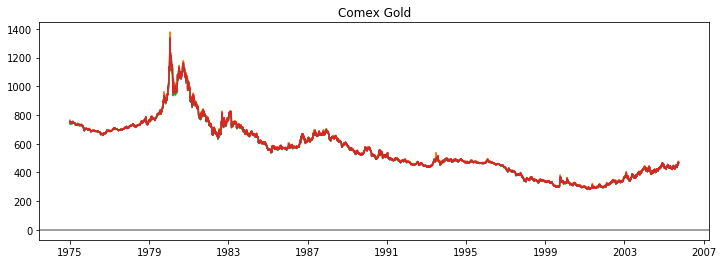

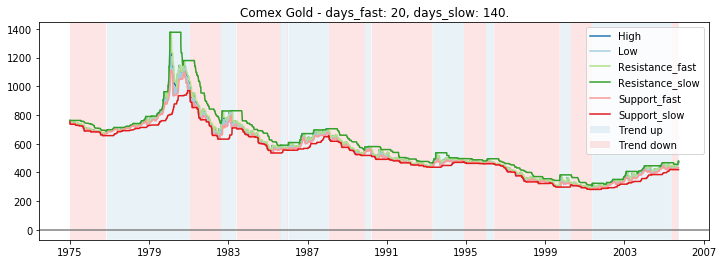

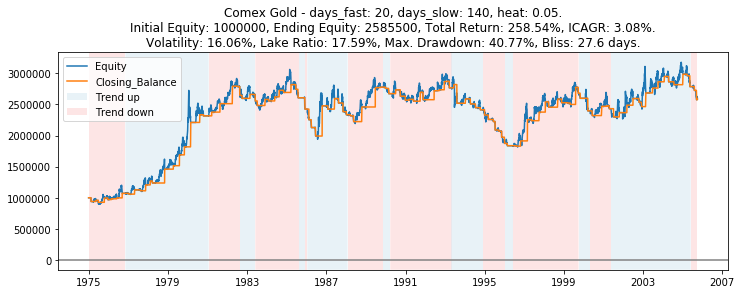

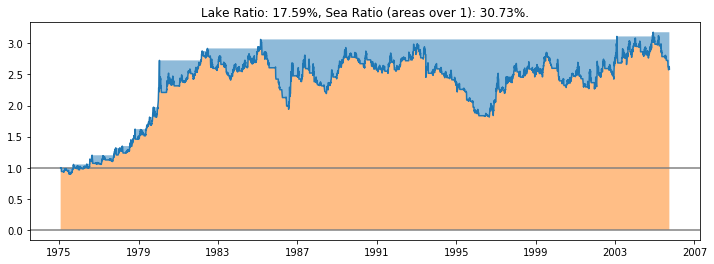

In [297]:
rs_tr.plot_prices()
rs_tr.plot_state()
rs_tr.plot_equity()
rs_tr.plot_lake_ratio()

## 3.3 With one asset

In [298]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]

In [299]:
pr_j = prices_dict[ticker_j]
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, days_fast=30, days_slow=120, name=str(j) + ' - ' + ticker_j)
tr_j.excecute(warmup=25)

In [303]:
tr_j.performance

{'Years': 11.371310912834591,
 'Ratio': 0.9774277921870004,
 'ICAGR': -0.0020077596955671495,
 'Max_Drawdown': 0.3632199082133992,
 'Bliss': -0.005527669739918411,
 'Volatility': 0.15858917103523387,
 'Lake_Ratio': 0.289826094458534,
 'Sea_Ratio': -43.99025171238139}

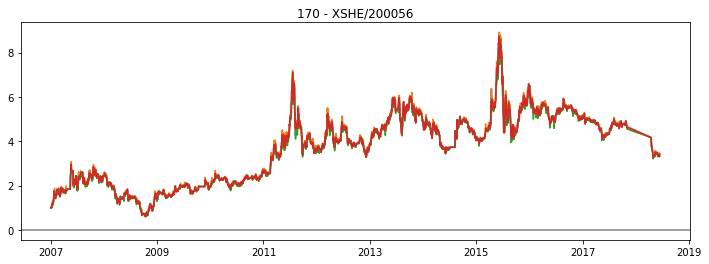

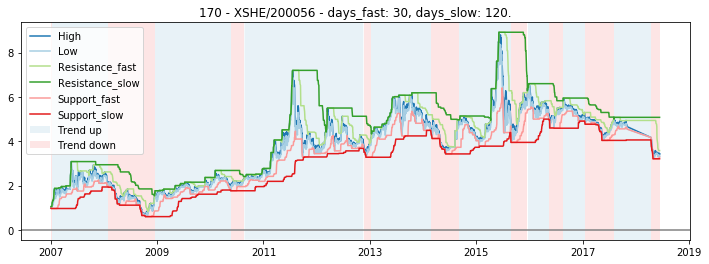

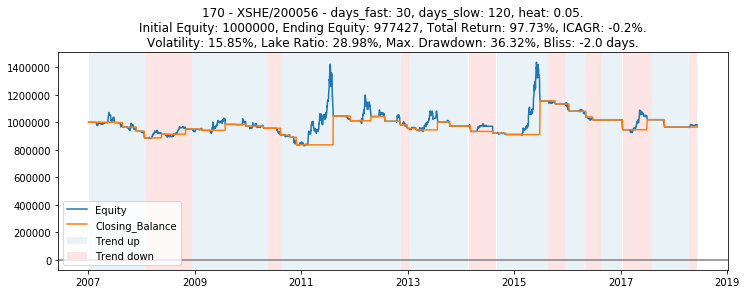

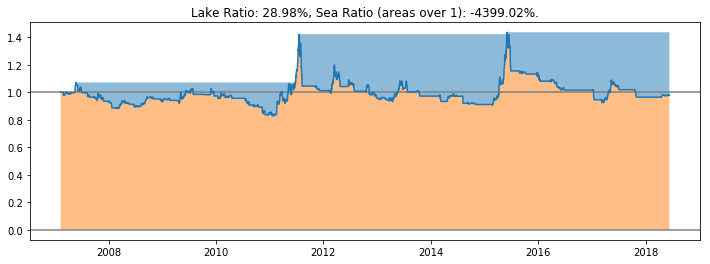

In [302]:
tr_j.plot_prices()
tr_j.plot_state()
tr_j.plot_equity()
tr_j.plot_lake_ratio()

### 3.3.1 Optimizing hyper parameters

In [304]:
slow = np.arange(20, 420, 20)
fast = np.arange(0.1, 0.9, 0.1)

trs = []
trs_val = []
for s, f in itertools.product(slow, fast):
    # Training
    tr = RS_Trading_Strategy(pr_j, equity=1e6,
                               days_fast=int(s * f), 
                               days_slow=s,
                               name=str(j) + ' - ' + ticker_j)
    tr.excecute(warmup=0.1, end = 0.45)
    trs.append({'Slow': s, 'Fast': str(int(s * f)), 'tr': tr})
    
    # Validation
    tr_val = RS_Trading_Strategy(pr_j, equity=1e6,
                                 days_fast=int(s * f), 
                                 days_slow=s,
                                 name=str(j) + ' - ' + ticker_j)
    tr_val.excecute(warmup=0.55)
    trs_val.append({'Slow': s, 'Fast': str(int(s * f)), 'tr': tr_val})

C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:419: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:414: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\e

In [305]:
res = pd.concat([dict_list_to_DataFrame([r['tr'].performance for r in trs]),
                 dict_list_to_DataFrame([{'Slow': r['Slow'], 'Fast': r['Fast']} for r in trs])],
                axis=1).set_index(['Slow', 'Fast'])
res

Years     Ratio     ICAGR  Max_Drawdown     Bliss  Volatility  \
Slow Fast                                                                     
20   2     3.862732       NaN       NaN      0.000000       NaN         NaN   
     4     3.862732       NaN       NaN      0.000000       NaN         NaN   
     6     3.862732       NaN       NaN      0.329533       NaN         NaN   
     8     3.862732  1.024329  0.006223      0.511607  0.012164    0.330987   
     10    3.862732  1.005300  0.001368      0.380229  0.003599    0.264308   
...             ...       ...       ...           ...       ...         ...   
400  160   3.862732  0.990148 -0.002563      0.193729 -0.013230    0.095888   
     200   3.862732  1.052482  0.013242      0.190822  0.069395    0.094246   
     240   3.862732  1.045603  0.011545      0.168563  0.068488    0.081666   
     280   3.862732  1.018768  0.004814      0.113770  0.042311    0.053479   
     320   3.862732  1.012196  0.003138      0.103999  0.030176    0.048913   

           Lake_Ratio  Sea_Ratio  
Slow Fast                         
20   2            NaN        NaN  
     4            NaN        NaN  
     6            NaN        NaN  
     8       0.342094   1.410107  
     10      0.204485   1.105609  
...               ...        ...  
400  160     0.058808  -2.740427  
     200     0.042786   9.092975  
     240     0.036070   7.929346  
     280     0.029700  -7.110553  
     320     0.029626  -4.235425  

[160 rows x 8 columns]

170 XSHE/200056


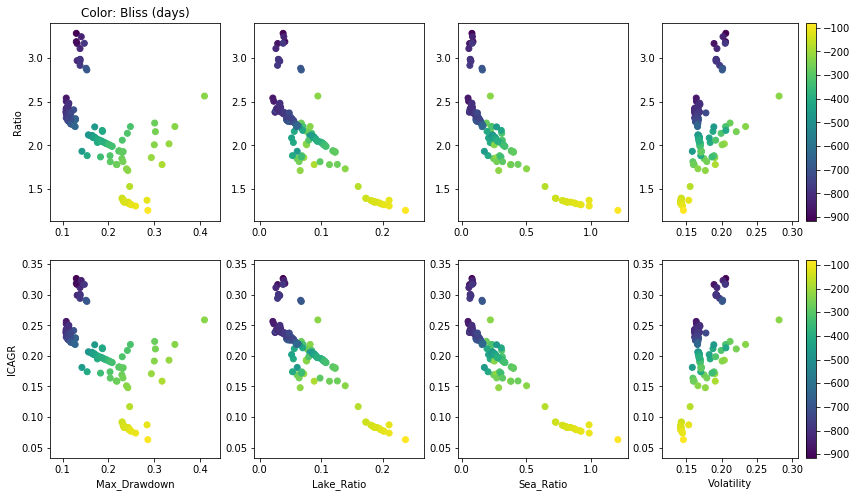

In [306]:
y_lab = ['Ratio', 'ICAGR']
x_lab = ['Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']
c_lab = 'Bliss'

print(j, ticker_j)
fig, axes = plt.subplots(nrows=len(y_lab), ncols=len(x_lab), squeeze=False, figsize=(14, 8))

axes[0, 0].set_title('Color: ' + c_lab + ' (days)')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[i, j].scatter(res_perf[x_lab[j]], res_perf[y_lab[i]], c=-res_perf[c_lab] * 364.25)    
    if i == len(y_lab) - 1:
        axes[i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[i, j])

In [307]:
res_val = pd.concat([dict_list_to_DataFrame([r['tr'].performance for r in trs_val]),
                    dict_list_to_DataFrame([{'Slow': r['Slow'], 'Fast': r['Fast']} for r in trs_val])],
                   axis=1).set_index(['Slow', 'Fast'])

3 XSHE/200056


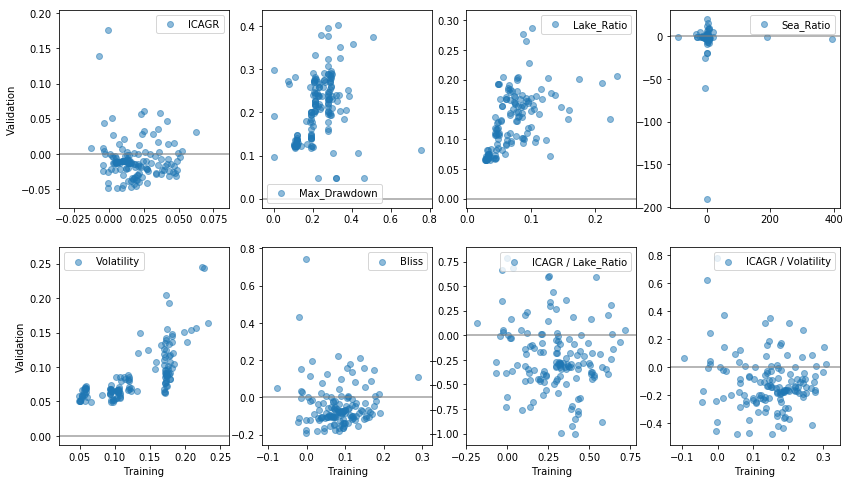

In [318]:
res['ICAGR / Lake_Ratio'] = res['ICAGR'] / res['Lake_Ratio']
res['ICAGR / Volatility'] = res['ICAGR'] / res['Volatility']
res_val['ICAGR / Lake_Ratio'] = res_val['ICAGR'] / res['Lake_Ratio']
res_val['ICAGR / Volatility'] = res_val['ICAGR'] / res['Volatility']

labs = ['ICAGR', 'Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio',
        'Volatility', 'Bliss', 'ICAGR / Lake_Ratio', 'ICAGR / Volatility']

print(j, ticker_j)
fig, axes = plt.subplots(nrows=2, ncols=4, squeeze=False, figsize=(14, 8))

for i in range(len(axes.flatten())):
    axes.flat[i].scatter(x=res[labs[i]], y=res_val[labs[i]], alpha = 0.5)
#     axes.flat[i].add_line(mpl.lines.Line2D(xdata=[-1e6, 1e6], ydata=[-1e6, 1e6], c='red', alpha=0.5))
    axes.flat[i].axhline(0, color='grey', alpha=0.75)
    axes.flat[i].legend()

axes.flat[4].set_xlabel('Training'); axes.flat[5].set_xlabel('Training'); axes.flat[6].set_xlabel('Training'); axes.flat[7].set_xlabel('Training');
axes.flat[0].set_ylabel('Validation'); axes.flat[4].set_ylabel('Validation');

### 3.3.2 Best configuration

In [344]:
s, f = res.ICAGR.idxmax(); print(j, s, f, sep=', ')
# s, f = res_perf.Bliss.idxmin(); print(j, s, f, sep=', ')
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, 
                           days_fast=int(f), days_slow=int(s),
                           name=str(j) + ' - ' + ticker_j)
tr_j.excecute()

3, 100, 10


C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:415: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\REUTERS\AppData\Local\conda\conda\envs\trend\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


In [345]:
tr_j.performance
# tr_j.get_equity()

{'Years': 11.371310912834591,
 'Ratio': nan,
 'ICAGR': nan,
 'Max_Drawdown': 0.3206001844961214,
 'Bliss': nan,
 'Volatility': 0.0,
 'Lake_Ratio': 0.21990712661680725,
 'Sea_Ratio': 1.42277690325168}

ValueError: cannot convert float NaN to integer

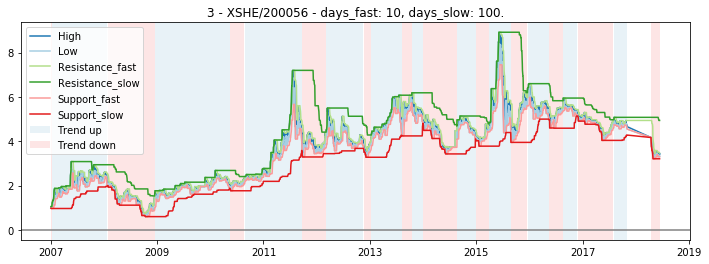

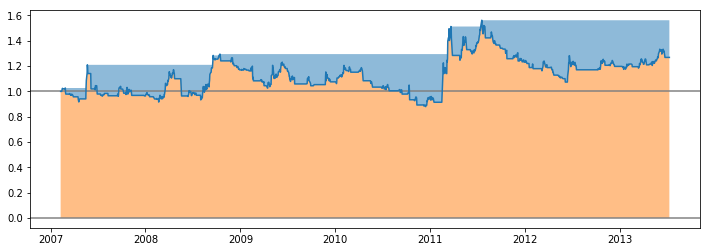

In [341]:
tr_j.plot_state()
# tr_j.plot_equity()
tr_j.plot_lake_ratio()

# TO DO:

* Download all series.
* Filter and curate series (eg. 
    * XNAS/AAPL
    * 152  -  XTSX/AMK
    * 38  -  XTSE/ACD